In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# VAE Encoder (Se)
class VAEEncoder(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=512, latent_dim=512):
        super(VAEEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1)  # 1024 -> 512
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # 512 -> 256
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)  # 256 -> 128
        self.conv4 = nn.Conv2d(256, hidden_dim, kernel_size=4, stride=2, padding=1)  # 128 -> 64
        self.fc_mu = nn.Linear(hidden_dim * 16 * 16, latent_dim)  # compressed to latent space
        self.fc_logvar = nn.Linear(hidden_dim * 16 * 16, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)  # flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# VAE Decoder (Si)
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim=512, hidden_dim=512, out_channels=3):
        super(VAEDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, hidden_dim * 16 * 16)
        self.conv1 = nn.ConvTranspose2d(hidden_dim, 256, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, 16, 16)  # reshape back to image size
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))  # output image
        return x

class TemporalTransformer(nn.Module):
    def __init__(self, seq_len=240, embed_dim=512, num_heads=8, depth=6):
        super(TemporalTransformer, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.fc = nn.Linear(embed_dim, embed_dim)  # to process the last hidden state

    def forward(self, x):
        # Input shape: (batch_size, seq_len, embed_dim)
        x = self.transformer(x)
        # Take the last hidden state as the conditional embedding
        cond_embedding = self.fc(x[:, -1, :])
        return x, cond_embedding

class DiffusionTransformer(nn.Module):
    def __init__(self, latent_dim=512, num_tokens=16*16, diffusion_steps=10, num_heads=8, depth=6):
        super(DiffusionTransformer, self).__init__()
        self.latent_dim = latent_dim
        self.num_tokens = num_tokens  # 16x16 tokens for one frame
        self.diffusion_steps = diffusion_steps

        # Define a transformer block
        encoder_layer = nn.TransformerEncoderLayer(d_model=latent_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # Linear projection to output full frame (16x16 tokens)
        self.fc_out = nn.Linear(latent_dim, latent_dim)

    def forward(self, cond_embedding):
        batch_size = cond_embedding.size(0)

        # Start with zero tensor of shape (batch_size, num_tokens, latent_dim)
        latent_tokens = torch.zeros(batch_size, self.num_tokens, self.latent_dim).to(cond_embedding.device)

        for step in range(self.diffusion_steps):
            # Apply transformer over all tokens
            latent_tokens = self.transformer(latent_tokens)

            # Use conditional embedding to guide the last token(s)
            # Here, instead of applying it to one token, we apply it over all tokens
            latent_tokens[:, -1, :] = cond_embedding  # Apply cond embedding to the last token

            # Linear projection over all tokens
            latent_tokens = self.fc_out(latent_tokens)

        decoded_input = latent_tokens.mean(dim=1) # Average over the tokens

        return decoded_input  # Return the reshaped latent representation

class WorldModel(nn.Module):
    def __init__(self):
        super(WorldModel, self).__init__()
        self.encoder = VAEEncoder()
        self.temporal_transformer = TemporalTransformer()
        self.diffusion_transformer = DiffusionTransformer()
        self.decoder = VAEDecoder()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # VAE Encoding (Se)
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)

        # Reshape z to match the expected transformer input (batch_size, seq_len, embed_dim)
        z_seq = z.view(x.size(0), -1, 512)

        # Temporal Transformer (Ni)
        hidden_states, cond_embedding = self.temporal_transformer(z_seq)

        # Diffusion Transformer (Ne)
        decoded_input = self.diffusion_transformer(cond_embedding)  # Get reshaped latent

        # VAE Decoding (Si)
        output = self.decoder(decoded_input)  # Decode the reshaped latent

        return output, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [2]:
import torch
import cv2
import torchvision.transforms as transforms
import os

from torch.utils.data import Dataset, DataLoader

class VideoDataset1(Dataset):
    def __init__(self, video_path, phase, clip_len=240, stride=120, frame_size=(256, 256), transform=None):
        self.video_path = video_path
        self.clip_len = clip_len
        self.stride = stride
        self.frame_size = frame_size
        self.transform = transform
        self.phase = phase

        if not os.path.exists(self.video_path):
            raise FileNotFoundError(f"Video file not found: {self.video_path}")

        self.total_frames = self._get_total_frames(self.video_path)

    def _get_total_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        return total_frames

    def __len__(self):
        if self.phase == 1:  # For VAE training, use the entire video
            # Ensure the result is non-negative by using max(0, ...)
            length = (self.total_frames - self.clip_len) // self.stride + 1
            # Print length to check if it's 0
            print(f"Dataset length (phase 1): {length}")  # Add this line for debugging
            return max(0, length)  # Return 0 if length is negative
        else:  # For transformer and full model training, predict the last frame
            # Ensure the result is non-negative by using max(0, ...)
            length = self.total_frames - self.clip_len  # Number of possible starting frames
            # Print length to check if it's 0
            print(f"Dataset length (phase 2/3): {length}")  # Add this line for debugging
            return max(0, length)  # Return 0 if length is negative


    def __getitem__(self, idx):

        cap = cv2.VideoCapture(self.video_path)

        if self.phase == 1:  # VAE training (return clips)
            start_frame = idx * self.stride
            clip = []
            for i in range(self.clip_len):
                cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame + i)
                ret, frame = cap.read()
                if not ret:
                    frame = torch.zeros(3, *self.frame_size, dtype=torch.uint8)
                else:
                    frame = torch.from_numpy(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).permute(2, 0, 1)
                    frame = transforms.functional.resize(frame, self.frame_size)
                clip.append(frame)
            clip = torch.stack(clip)

        else: # Transformer and full model training (return sequence and target last frame)
            start_frame = idx
            clip = [] #Sequence
            for i in range(self.clip_len): # Sequence frames
                cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame + i)
                ret, frame = cap.read()
                if not ret:
                    frame = torch.zeros(3, *self.frame_size, dtype=torch.uint8)
                else:
                    frame = torch.from_numpy(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).permute(2, 0, 1)
                    frame = transforms.functional.resize(frame, self.frame_size)
                clip.append(frame)

            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame + self.clip_len) # Target frame
            ret, target_frame = cap.read()
            if not ret:
                target_frame = torch.zeros(3, *self.frame_size, dtype=torch.uint8)
            else:
                target_frame = torch.from_numpy(cv2.cvtColor(target_frame, cv2.COLOR_BGR2RGB)).permute(2, 0, 1)
                target_frame = transforms.functional.resize(target_frame, self.frame_size)
            clip = torch.stack(clip)

        cap.release()


        if self.transform:
            if self.phase == 1:
                clip = self.transform(clip)
            else:
                clip = self.transform(clip)
                target_frame = self.transform(target_frame)


        if self.phase == 1:
          return clip
        else:
          return clip, target_frame

class VideoDataset2(Dataset):
    def __init__(self, video_path, phase, clip_len=240, stride=120, frame_size=(256, 256), transform=None):
        self.video_path = video_path
        self.clip_len = clip_len
        self.stride = stride
        self.frame_size = frame_size
        self.transform = transform
        self.phase = phase

        if not os.path.exists(self.video_path):
            raise FileNotFoundError(f"Video file not found: {self.video_path}")

        self.total_frames = self._get_total_frames(self.video_path)

    def _get_total_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        return total_frames

    def __len__(self):
        if self.phase == 1:  # For VAE training, use the entire video
            # Ensure the result is non-negative by using max(0, ...)
            length = (self.total_frames - self.clip_len) // self.stride + 1
            # Print length to check if it's 0
            print(f"Dataset length (phase 1): {length}")  # Add this line for debugging
            return max(0, length)  # Return 0 if length is negative
        else:  # For transformer and full model training, predict the last frame
            # Ensure the result is non-negative by using max(0, ...)
            length = self.total_frames - self.clip_len  # Number of possible starting frames
            # Print length to check if it's 0
            print(f"Dataset length (phase 2/3): {length}")  # Add this line for debugging
            return max(0, length)  # Return 0 if length is negative


    def __getitem__(self, idx):

        cap = cv2.VideoCapture(self.video_path)

        if self.phase == 1:  # VAE training (return clips)
            start_frame = idx * self.stride
            clip = []
            for i in range(self.clip_len):
                cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame + i)
                ret, frame = cap.read()
                if not ret:
                    frame = torch.zeros(3, *self.frame_size, dtype=torch.uint8)
                else:
                    frame = torch.from_numpy(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).permute(2, 0, 1)
                    frame = transforms.functional.resize(frame, self.frame_size)
                clip.append(frame)
            clip = torch.stack(clip)

        else: # Transformer and full model training (return sequence and target last frame)
            start_frame = idx
            clip = [] #Sequence
            for i in range(self.clip_len): # Sequence frames
                cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame + i)
                ret, frame = cap.read()
                if not ret:
                    frame = torch.zeros(3, *self.frame_size, dtype=torch.uint8)
                else:
                    frame = torch.from_numpy(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).permute(2, 0, 1)
                    frame = transforms.functional.resize(frame, self.frame_size)
                clip.append(frame)

            cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame + self.clip_len) # Target frame
            ret, target_frame = cap.read()
            if not ret:
                target_frame = torch.zeros(3, *self.frame_size, dtype=torch.uint8)
            else:
                target_frame = torch.from_numpy(cv2.cvtColor(target_frame, cv2.COLOR_BGR2RGB)).permute(2, 0, 1)
                target_frame = transforms.functional.resize(target_frame, self.frame_size)
            clip = torch.stack(clip)

        cap.release()


        if self.transform:
            if self.phase == 1:
                clip = self.transform(clip)
            else:
                clip = self.transform(clip)
                target_frame = self.transform(target_frame)


        if self.phase == 1:
          return clip
        else:
          return clip, target_frame

video_path = "video.mp4"  # Provide the local path to your video file


video_transform = transforms.Compose([
    transforms.Lambda(lambda x: x / 255.0),  # Normalize to [0, 1]
    transforms.ConvertImageDtype(torch.float)
])

# Create dataloaders for each training phase

# Phase 1: VAE Training
# vae_dataset = VideoDataset1(video_path, phase=1, clip_len=48, stride=12, frame_size=(256, 256), transform=video_transform)
# vae_dataloader = DataLoader(vae_dataset, batch_size=1, shuffle=True, num_workers=4)

# Phase 2 & 3: Transformer and Full Model Training
transformer_dataset = VideoDataset2(video_path, phase=2, clip_len=12, stride=6, frame_size=(256, 256), transform=video_transform)  # Use phase=2 or 3
transformer_dataloader = DataLoader(transformer_dataset, batch_size=1, shuffle=False, num_workers=4)  # Don't shuffle for next-frame prediction

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [3]:
import torch
import torch.nn.functional as F

# PHASE 1: Train the VAE (Se and Si)
def train_vae(model, dataloader, optimizer, num_epochs=10, device='cuda'):
    model.train()
    for epoch in range(num_epochs):
        for batch_idx, frames in enumerate(dataloader):
            # Reshape frames to (batch_size * clip_len, channels, height, width)
            frames = frames.view(-1, frames.shape[2], frames.shape[3], frames.shape[4]).to(device)

            optimizer.zero_grad()

            # Forward pass through ONLY VAE encoder and decoder
            mu, logvar = model.encoder(frames)
            z = model.reparameterize(mu, logvar) # Crucial for VAE training
            recon = model.decoder(z)

            # Reshape recon to match the original frames shape for loss calculation
            recon = recon.view(frames.shape[0], -1, recon.shape[1], recon.shape[2], recon.shape[3])

            loss = vae_loss(recon, frames, mu, logvar)

            loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item()}')

    print('Phase 1: VAE training completed!')

# PHASE 2: Train Transformer (Ni) and Diffusion Transformer (Ne) with VAE Frozen
def train_transformer_with_frozen_vae(model, dataloader, optimizer, num_epochs=10, device='cuda'):
    # Freeze VAE
    for param in model.encoder.parameters():
        param.requires_grad = False
    for param in model.decoder.parameters():
        param.requires_grad = False

    model.train()
    for epoch in range(num_epochs):
        for batch_idx, (clip, target_frame) in enumerate(dataloader): # Unpack the tuple
            clip = clip.to(device) # Move sequence to device
            target_frame = target_frame.to(device) # Move target frame to device
            optimizer.zero_grad()

            # Reshape clip to (batch_size * clip_len, channels, height, width) before passing to the model
            clip_reshaped = clip.view(-1, clip.shape[2], clip.shape[3], clip.shape[4])

            recon, mu, logvar = model(clip_reshaped)  # Pass the reshaped clip to the model
            loss = F.mse_loss(recon, target_frame) # Calculate loss against the target frame

            loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item()}')

    print('Phase 2: Transformer and Diffusion Transformer training with frozen VAE completed!')

# PHASE 3: Train the whole world model with next-frame prediction
def train_full_model(model, dataloader, optimizer, num_epochs=10, device='cuda'):
    model.train()
    for epoch in range(num_epochs):
        for batch_idx, (clip, target_frame) in enumerate(dataloader): # Unpack the tuple
            clip = clip.to(device) # Move sequence to device
            target_frame = target_frame.to(device) # Move target frame to device
            optimizer.zero_grad()

            # Reshape clip to (batch_size * clip_len, channels, height, width) before passing to the model
            clip_reshaped = clip.view(-1, clip.shape[2], clip.shape[3], clip.shape[4])

            recon, mu, logvar = model(clip_reshaped)  # Pass the reshaped clip to the model
            loss = F.mse_loss(recon, target_frame) # Calculate loss against the target frame

            loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item()}')

    print('Phase 3: Full world model training completed!')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = WorldModel().to(device)

# Example optimizer setup
# vae_params = list(model.encoder.parameters()) + list(model.decoder.parameters())
# optimizer_vae = torch.optim.Adam(vae_params, lr=1e-4)

# transformer_params = list(model.temporal_transformer.parameters()) + list(model.diffusion_transformer.parameters())
# optimizer_transformer = torch.optim.Adam(transformer_params, lr=1e-4)

full_model_params = list(model.parameters())  # This includes VAE, temporal transformer, and diffusion transformer
optimizer_full = torch.optim.Adam(full_model_params, lr=1e-5)


# Dataloaders and dataset assumed to be already defined
# `dataloader` is your DataLoader object

# PHASE 1: Train VAE
# train_vae(model, vae_dataloader, optimizer_vae, num_epochs=10, device=device)

# PHASE 2: Train transformer and diffusion transformer with VAE frozen
# train_transformer_with_frozen_vae(model, transformer_dataloader, optimizer_transformer, num_epochs=10, device=device)

# PHASE 3: Fine-tune the full world model
train_full_model(model, transformer_dataloader, optimizer_full, num_epochs=5, device=device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Dataset length (phase 2/3): 892


<ipython-input-3-1b5acd1537be>:74: UserWarning: Using a target size (torch.Size([1, 3, 256, 256])) that is different to the input size (torch.Size([12, 3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(recon, target_frame) # Calculate loss against the target frame


Epoch 0/5, Batch 0, Loss: 0.15155145525932312
Epoch 0/5, Batch 10, Loss: 0.13437433540821075
Epoch 0/5, Batch 20, Loss: 0.13322079181671143
Epoch 0/5, Batch 30, Loss: 0.13261157274246216
Epoch 0/5, Batch 40, Loss: 0.1314259171485901
Epoch 0/5, Batch 50, Loss: 0.12934616208076477
Epoch 0/5, Batch 60, Loss: 0.12525643408298492
Epoch 0/5, Batch 70, Loss: 0.11709056794643402
Epoch 0/5, Batch 80, Loss: 0.1026582419872284
Epoch 0/5, Batch 90, Loss: 0.08054281771183014
Epoch 0/5, Batch 100, Loss: 0.05901787057518959
Epoch 0/5, Batch 110, Loss: 0.043479181826114655
Epoch 0/5, Batch 120, Loss: 0.033143624663352966
Epoch 0/5, Batch 130, Loss: 0.027835892513394356
Epoch 0/5, Batch 140, Loss: 0.02602509595453739
Epoch 0/5, Batch 150, Loss: 0.025319909676909447
Epoch 0/5, Batch 160, Loss: 0.023819483816623688
Epoch 0/5, Batch 170, Loss: 0.022797206416726112
Epoch 0/5, Batch 180, Loss: 0.021315671503543854
Epoch 0/5, Batch 190, Loss: 0.020862068980932236
Epoch 0/5, Batch 200, Loss: 0.021612146869301

KeyboardInterrupt: 

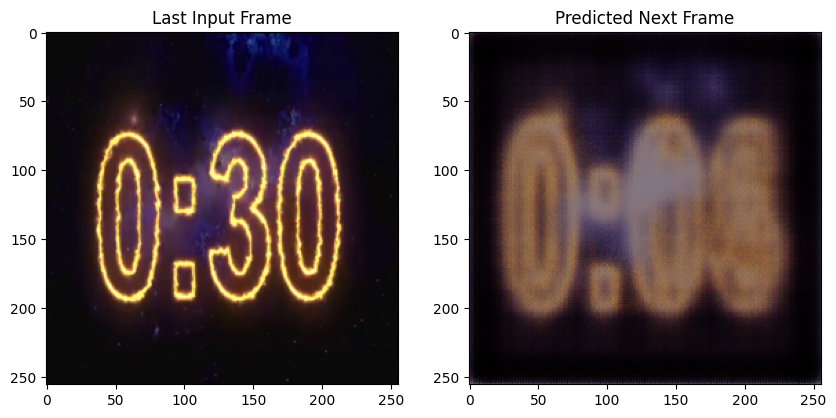

In [6]:
import torch
import cv2
import torchvision.transforms as transforms
import matplotlib.pyplot as plt  # For displaying images
import numpy as np

model.eval()  # Set the model to evaluation mode

# Function to load and process a single video clip
def process_video_clip(video_path, clip_len=12, frame_size=(256, 256)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    for i in range(clip_len):
        ret, frame = cap.read()
        if not ret:
            # Handle end of video (pad with zeros or break)
            frame = np.zeros((frame_size[1], frame_size[0], 3), dtype=np.uint8)
        frame = torch.from_numpy(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).permute(2, 0, 1)
        frame = transforms.functional.resize(frame, frame_size)
        frames.append(frame)
    cap.release()
    clip = torch.stack(frames).to(device)  # Move to device
    clip = video_transform(clip)
    return clip

# Load and process the video clip
input_clip = process_video_clip(video_path)

with torch.no_grad():  # No need to calculate gradients during inference
    predicted_next_frame, _, _ = model(input_clip) # Get the predicted next frame

    # Select the last predicted frame from the sequence (if it's a sequence)
    predicted_next_frame = predicted_next_frame[-1]

# Convert the predicted frame to a displayable format
predicted_next_frame = predicted_next_frame.squeeze(0).cpu().permute(1, 2, 0).numpy()
predicted_next_frame = (predicted_next_frame * 255).astype(np.uint8)  # Convert back to 0-255 range
predicted_next_frame = cv2.cvtColor(predicted_next_frame, cv2.COLOR_RGB2BGR)  # Convert back to BGR


# Get the last frame of the input clip for comparison (convert to same format as predicted frame)
last_input_frame = input_clip[-1].squeeze(0).cpu().permute(1, 2, 0).numpy()
last_input_frame = (last_input_frame*255).astype(np.uint8)
last_input_frame = cv2.cvtColor(last_input_frame, cv2.COLOR_RGB2BGR)

# Display the last input frame and the predicted next frame
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(last_input_frame)
plt.title("Last Input Frame")
plt.subplot(1, 2, 2)
plt.imshow(predicted_next_frame)
plt.title("Predicted Next Frame")
plt.show()